# Mutual Information Estimation Quality

In this experiment, we compare our CLUB estimator with other baselines on MI estimation quality. 
First, we draw samples from Gaussian and Cubic distributions with the true MI values pre-known. Then we compare different MI estimators on estimating MI values based on the generated samples. 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import time

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

First, we define the sampling function, which can sample Gaussian or Cubic data with the given correlation coefficient $\rho$:

In [2]:
def sample_correlated_gaussian(rho=0.5, dim=20, batch_size=128, to_cuda=False,cubic=None):
    """Generate samples from a correlated Gaussian distribution."""
    mean = [0,0]
    cov = [[1.0, rho],[rho, 1.0]]
    x, y = np.random.multivariate_normal(mean, cov, batch_size * dim).T

    x = x.reshape(-1, dim)
    y = y.reshape(-1, dim)

    if cubic is not None:
        y = y ** 3

    if to_cuda:
        x = torch.from_numpy(x).float().cuda()
        #x = torch.cat([x, torch.randn_like(x).cuda() * 0.3], dim=-1)
        y = torch.from_numpy(y).float().cuda()
    return x, y

Under the Gaussian distribution, the correlation coefficient and mutual information have one-to-one mapping:

In [3]:
def rho_to_mi(rho, dim):
    result = -dim / 2 * np.log(1 - rho **2)
    return result


def mi_to_rho(mi, dim):
    result = np.sqrt(1 - np.exp(-2 * mi / dim))
    return result

In [4]:
sample_dim = 20
batch_size = 64
hidden_size = 15
learning_rate = 0.005
training_steps = 4000

cubic = False
model_list = ["NWJ", "MINE", "InfoNCE","L1OutUB","CLUB","CLUBSample"]
#model_list = [ "MINE","CLUBSample"]

mi_list = [2.0, 4.0, 6.0, 8.0, 10.0]

total_steps = training_steps*len(mi_list)

Train different MI estimators with samples drawn from different Gaussian or Cubic distributions with different MI true values:

In [5]:
# train MI estimators with samples 
from mi_estimators import *

mi_results = dict()
for i, model_name in enumerate(model_list):
    
    model = eval(model_name)(sample_dim, sample_dim, hidden_size).cuda()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    mi_est_values = []

    start_time = time.time()
    for i, mi_value in enumerate(mi_list):
        rho = mi_to_rho(mi_value, sample_dim)

        for step in range(training_steps):
            batch_x, batch_y = sample_correlated_gaussian(rho, dim=sample_dim, batch_size = batch_size, to_cuda = True, cubic = cubic)

            model.eval()
            mi_est_values.append(model.mi_est(batch_x, batch_y).item())
            
            model.train() 
            if model_name in ["MINE", "InfoNCE","NWJ"]:
                model_loss = - model.mi_est(batch_x, batch_y)
            elif model_name in ["CLUB","CLUBSample","L1OutUB","VarUB"]:
                model_loss = - model.loglikeli(batch_x, batch_y)
           
            optimizer.zero_grad()
            model_loss.backward()
            optimizer.step()
            
            del batch_x, batch_y
            torch.cuda.empty_cache()

        print("finish training for %s with true MI value = %f" % (model.__class__.__name__, mi_value))
        # torch.save(model.state_dict(), "./model/%s_%d.pt" % (model.__class__.__name__, int(mi_value)))
        torch.cuda.empty_cache()
    end_time = time.time()
    time_cost = end_time - start_time
    print("model %s average time cost is %f s" % (model_name, time_cost/total_steps))
    mi_results[model_name] = mi_est_values

finish training for NWJ with true MI value = 2.000000
finish training for NWJ with true MI value = 4.000000
finish training for NWJ with true MI value = 6.000000
finish training for NWJ with true MI value = 8.000000
finish training for NWJ with true MI value = 10.000000
model NWJ average time cost is 0.003926 s
finish training for MINE with true MI value = 2.000000
finish training for MINE with true MI value = 4.000000
finish training for MINE with true MI value = 6.000000
finish training for MINE with true MI value = 8.000000
finish training for MINE with true MI value = 10.000000
model MINE average time cost is 0.003322 s
finish training for InfoNCE with true MI value = 2.000000
finish training for InfoNCE with true MI value = 4.000000
finish training for InfoNCE with true MI value = 6.000000
finish training for InfoNCE with true MI value = 8.000000
finish training for InfoNCE with true MI value = 10.000000
model InfoNCE average time cost is 0.003751 s
finish training for L1OutUB wit

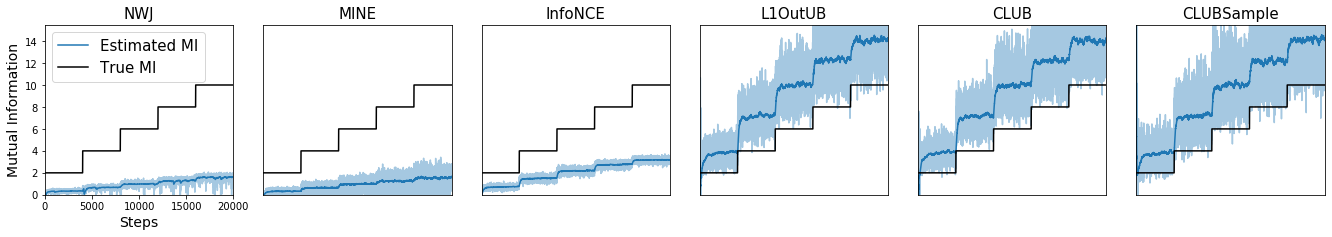

In [6]:
import seaborn as sns
import pandas as pd
colors = sns.color_palette()

EMA_SPAN = 200

ncols = len(model_list)
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(3.1 *ncols , 3.4 * nrows))
axs = np.ravel(axs)


xaxis = np.array(list(range(total_steps)))
yaxis_mi = np.repeat(mi_list, training_steps)

for i, model_name in enumerate(model_list):
    plt.sca(axs[i])
    p1 = plt.plot(mi_results[model_name], alpha=0.4, color=colors[0])[0]  #color = 5 or 0
    mis_smooth = pd.Series(mi_results[model_name]).ewm(span=EMA_SPAN).mean()
    
    if i == 0:
        plt.plot(mis_smooth, c=p1.get_color(), label='Estimated MI')
        plt.plot(yaxis_mi, color='k', label='True MI')
        plt.xlabel('Steps', fontsize= 14)
        plt.ylabel('Mutual Information', fontsize = 14)
        plt.legend(loc='upper left', prop={'size':15})
    else:
        plt.plot(mis_smooth, c=p1.get_color())
        plt.yticks([])
        plt.plot(yaxis_mi, color='k')
        plt.xticks([])
    
    plt.ylim(0, 15.5)
    plt.xlim(0, total_steps)   
    plt.title(model_name, fontsize=15)
    #plt.subplots_adjust( )

plt.gcf().tight_layout()
#plt.savefig(f'mi_gauss_py.pdf', bbox_inches=None)

Calculate the bias, variance and mean-squared-error (MSE) of the estimated MI to the true MI values:

In [7]:
bias_dict = dict()
var_dict = dict()
mse_dict = dict()
for i, model_name in enumerate(model_list):
    bias_list = []
    var_list = []
    mse_list = []
    for j in range(len(mi_list)):
        mi_est_values = mi_results[model_name][training_steps*(j+1)- 500:training_steps*(j+1)]
        est_mean = np.mean(mi_est_values)
        bias_list.append(np.abs(mi_list[j] - est_mean))
        var_list.append(np.var(mi_est_values))
        mse_list.append(bias_list[j]**2+ var_list[j])
    bias_dict[model_name] = bias_list
    var_dict[model_name] = var_list
    mse_dict[model_name] = mse_list

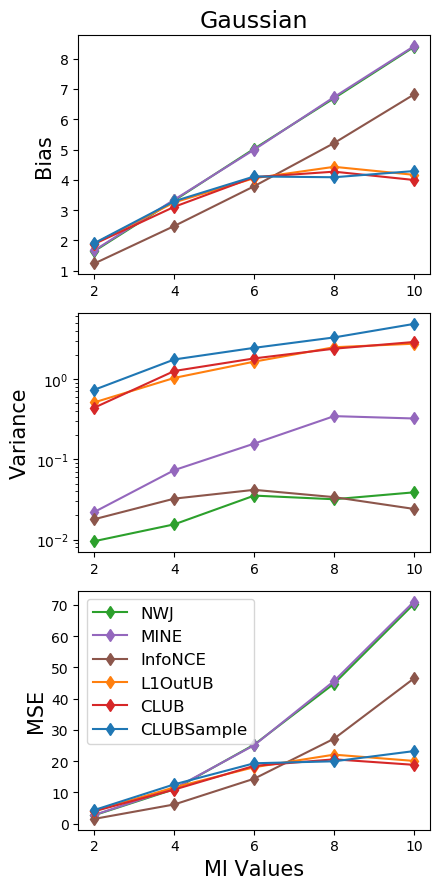

In [8]:
plt.style.use('default')#('seaborn-notebook')

colors = list(plt.rcParams['axes.prop_cycle'])
col_idx = [2,4,5,1,3,0]

ncols = 1
nrows = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 3. * nrows))
axs = np.ravel(axs)

for i, model_name in enumerate(model_list):
    plt.sca(axs[0])
    plt.plot(mi_list, bias_dict[model_name], label=model_name, marker='d', color = colors[col_idx[i]]["color"]) 
    
    plt.sca(axs[1])
    plt.plot(mi_list, var_dict[model_name], label=model_name, marker='d', color = colors[col_idx[i]]["color"]) 
    
    plt.sca(axs[2])
    plt.plot(mi_list, mse_dict[model_name], label=model_name, marker='d', color = colors[col_idx[i]]["color"]) 
        
ylabels = ['Bias', 'Variance', 'MSE']
for i in range(3):
    plt.sca(axs[i])
    plt.ylabel(ylabels[i], fontsize=15)
    
    if i == 0:
        if cubic:
            plt.title('Cubic', fontsize=17)
        else:
            plt.title('Gaussian', fontsize=17)
    if i == 1:
        plt.yscale('log')
    if i == 2:
        plt.legend(loc='upper left', prop={'size': 12})
        plt.xlabel('MI Values',fontsize=15)
        
plt.gcf().tight_layout()
#plt.savefig(f'bias_variance_cubic_py3.pdf', bbox_inches='tight')